# Q18 Quick Start

This template shows you the basic steps for taking part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

fetched chunk 1/5 0s
fetched chunk 2/5 0s
fetched chunk 3/5 0s
fetched chunk 4/5 0s
fetched chunk 5/5 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2022-09-30,1.022457,0.009276,0.139296,-0.208734,-0.436348,0.009536,0.001328,-0.579832,230.0,0.035404,93.709258
2022-10-03,1.006384,-0.015720,0.139333,-0.221173,-0.436348,0.002730,0.000380,-0.579832,230.0,0.035403,93.701276
2022-10-04,0.982636,-0.023598,0.139436,-0.239551,-0.436348,-0.007501,-0.001046,-0.579832,230.0,0.035415,93.726820
2022-10-05,0.982202,-0.000442,0.139420,-0.239887,-0.436348,-0.007689,-0.001072,-0.579832,230.0,0.035417,93.730541
2022-10-06,0.987871,0.005771,0.139410,-0.235500,-0.436348,-0.005225,-0.000728,-0.579832,230.0,0.035412,98.462394


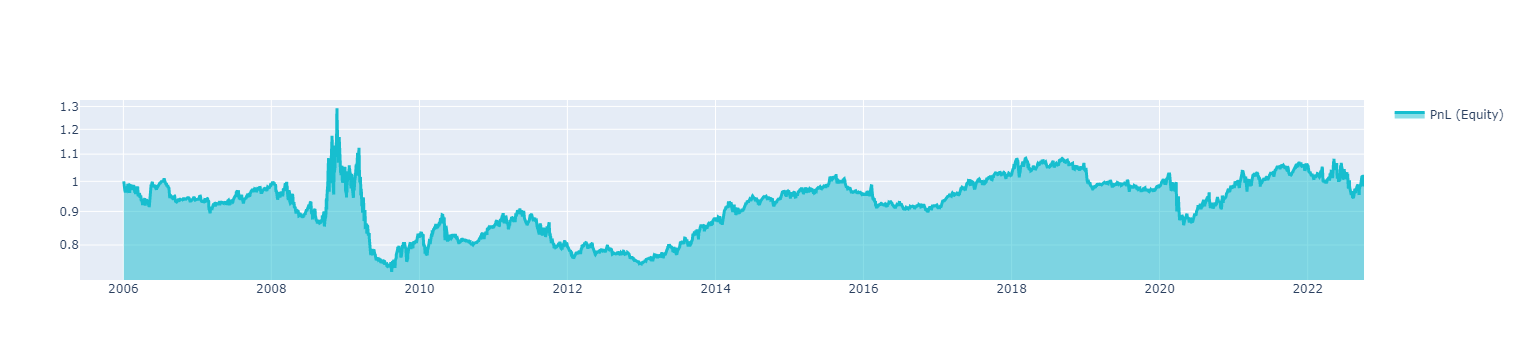

Sharpe Ratio:  -0.06383220938922404


In [2]:
# ! conda install -y scikit-learn

import xarray as xr

import qnt.ta as qnta
import qnt.data as qndata
import qnt.output as qnout
import qnt.stats as qns
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(min_date="2005-06-01")

close     = data.sel(field="close")
is_liquid = data.sel(field="is_liquid")
sma_slow  = qnta.sma(close, 250)
sma_fast  = qnta.sma(close, 10)
weights   = xr.where(sma_slow < sma_fast, 1, -1)
weights   = weights * is_liquid

weights = qnout.clean(weights, data, "stocks_nasdaq100")

# calc stats
stats = qns.calc_stat(data, weights.sel(time=slice("2006-01-01", None)))
display(stats.to_pandas().tail())

# graph
performance = stats.to_pandas()["equity"]
import qnt.graph as qngraph

qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights)
print("Sharpe Ratio: ",sharpe)

In [ ]:
weights = weights.sel(time=slice("2006-01-01",None))

qnout.check(weights, data, "stocks_nasdaq100")
qnout.write(weights) # to participate in the competition

# Description

## 1. Data

![data_example](./img/data.jpg)

The variable **qndata.stocks.load_ndx_data(tail=period)** is an xarray.DataArray structure which contains historical market data for the last (tail=period) days and whose coordinates are:

* **time**: a date in format yyyy-mm-dd;
* **field**: an attribute, for example the opening daily price;
* **asset**: the identifying symbol for the asset, for example NAS:APPL for Apple.

More details on xarray can be found at https://xarray.pydata.org/en/stable/.

## 2. Strategy. Weights allocation


![weights_example](./img/weights.jpg)

For each date, the algorithm calculates the portfolio weights which should be used at the opening of the next day's trading.

Quantiacs uses an exposure-based backtester. The trading algorithm should define the fractions of capital which will be distributed to the assets (allocation weights). A **positive** weight means a long position (**buy**), a **negative** value means a short position (**sell**).

> Note that algorithm decisions can use all data available at the close of the session, and will be applied at the opening of the next day's session. The chosen allocation weights are translated to positions (number of contracts to be bought/sold) immediately after the close of the session and transactions are executed at the open of the next day.


## 3. Performance estimation

![statistic_example](./img/statistic.png)

After we have built the algorithm, we can evaluate its performance calculating statistics.

We can display the values of statistical indicators on a cumulative basis, assuming that we have 1M USD at the starting point.

The call will produce:

* **equity**: the cumulative value of profits and losses since inception (1M USD);
* **relative_return**: the relative daily variation of **equity**;
* **volatility**: the volatility of the investment since inception (i.e. the annualized standard deviation of the daily returns);
* **underwater**: the time evolution of drawdowns;
* **max_drawdown**: the absolute minimum of the underwater chart;
* **sharpe_ratio**: the annualized Sharpe ratio since inception; the value must be larger than 1 for taking part to contests;
* **mean_return**: the annualized mean return of the investment since inception;
* **bias**: the daily asymmetry between long and short exposure: 1 for a long-only system, -1 for a short-only one;
* **instruments**: the number of instruments which get allocations on a given day;
* **avg_turnover**: the average turnover;
* **avg_holding_time**: the average holding time in days.

A detailed explanation can be found inspecting the source code for the library in your directory at **/qnt/stats.py**

Moreover we can produce a chart which shows the cumulative profits and losses.

# Alternative way of writing strategies

A quick prototpye can be written using a single-pass implementation where all the time series are processed at once. Beware that unintentional forward looking can take place!

> If strategy sharpe coefficient in the competition differs from the sharpe coefficient in jupyter, rewrite the strategy for Multi-Pass

<br>


<table style="text-align: left ; font-size: 1em ; min-width: 1000px">
<tbody><tr>
<td style="text-align: left"> Single-pass (quick check of the result)</td> <td style="text-align: left"> Multi-Pass equivalent</td>
</tr>
<tr>
<td style="text-align: left ; min-width: 500px">

<pre><code class="cm-s-ipython language-python"><span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">xarray</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">xr</span>

<span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">qnt</span>.<span class="cm-property">ta</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">qnta</span>
<span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">qnt</span>.<span class="cm-property">data</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">qndata</span>
<span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">qnt</span>.<span class="cm-property">output</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">qnout</span>
<span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">qnt</span>.<span class="cm-property">stats</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">qns</span>

<span class="cm-variable">data</span> <span class="cm-operator">=</span> <span class="cm-variable">qndata</span>.<span class="cm-property">stocks</span>.<span class="cm-property">load_ndx_data</span>(<span class="cm-variable">min_date</span><span class="cm-operator">=</span><span style=" color: #BA2121;">"2006-01-01"</span>)

<span class="cm-variable">close</span>     <span class="cm-operator">=</span> <span class="cm-variable">data</span>.<span class="cm-property">sel</span>(<span class="cm-variable">field</span><span class="cm-operator">=</span><span style=" color: #BA2121;">"close"</span>)
<span class="cm-variable">is_liquid</span> <span class="cm-operator">=</span> <span class="cm-variable">data</span>.<span class="cm-property">sel</span>(<span class="cm-variable">field</span><span class="cm-operator">=</span><span style=" color: #BA2121;">"is_liquid"</span>)
<span class="cm-variable">sma_slow</span>  <span class="cm-operator">=</span> <span class="cm-variable">qnta</span>.<span class="cm-property">sma</span>(<span class="cm-variable">close</span>, <span style=" color: #080;">200</span>)
<span class="cm-variable">sma_fast</span>  <span class="cm-operator">=</span> <span class="cm-variable">qnta</span>.<span class="cm-property">sma</span>(<span class="cm-variable">close</span>, <span style=" color: #080;">20</span>)
<span class="cm-variable">weights</span>   <span class="cm-operator">=</span> <span class="cm-variable">xr</span>.<span class="cm-property">where</span>(<span class="cm-variable">sma_slow</span> <span class="cm-operator">&lt;</span> <span class="cm-variable">sma_fast</span>, <span style=" color: #080;">1</span>, <span class="cm-operator">-</span><span style=" color: #080;">1</span>)
<span class="cm-variable">weights</span>   <span class="cm-operator">=</span> <span class="cm-variable">weights</span> <span class="cm-operator">*</span> <span class="cm-variable">is_liquid</span>

<span class="cm-variable">weights</span> <span class="cm-operator">=</span> <span class="cm-variable">qnout</span>.<span class="cm-property">clean</span>(<span class="cm-variable">weights</span>, <span class="cm-variable">data</span>, <span style=" color: #BA2121;">"stocks_nasdaq100"</span>)

<span class="cm-variable">qnout</span>.<span class="cm-property">check</span>(<span class="cm-variable">weights</span>, <span class="cm-variable">data</span>, <span style=" color: #BA2121;">"stocks_nasdaq100"</span>)

<span class="cm-variable">qnout</span>.<span class="cm-property">write</span>(<span class="cm-variable">weights</span>)

<span class="cm-comment"># calc stats</span>
<span class="cm-variable">stats</span> <span class="cm-operator">=</span> <span class="cm-variable">qns</span>.<span class="cm-property">calc_stat</span>(<span class="cm-variable">data</span>, <span class="cm-variable">weights</span>.<span class="cm-property">sel</span>(<span class="cm-variable">time</span><span class="cm-operator">=</span><span class="cm-builtin">slice</span>(<span style=" color: #BA2121;">"2006-01-01"</span>,<span style=" color: #008000;  font-weight: bold;">None</span>)))
<span class="cm-variable">stats</span>.<span class="cm-property">to_pandas</span>().<span class="cm-property">tail</span>()</code></pre>
</td>
<td style="text-align: left ; min-width: 500px">

<pre><code class="cm-s-ipython language-python"><span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">xarray</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">xr</span>

<span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">qnt</span>.<span class="cm-property">ta</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">qnta</span>
<span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">qnt</span>.<span class="cm-property">backtester</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">qnbt</span>
<span style=" color: #008000;  font-weight: bold;">import</span> <span class="cm-variable">qnt</span>.<span class="cm-property">data</span> <span style=" color: #008000;  font-weight: bold;">as</span> <span class="cm-variable">qndata</span>



<span style=" color: #008000;  font-weight: bold;">def</span> <span style=" color:  #00f;">load_data</span>(<span class="cm-variable">period</span>):
    <span style=" color: #008000;  font-weight: bold;">return</span> <span class="cm-variable">qndata</span>.<span class="cm-property">stocks</span>.<span class="cm-property">load_ndx_data</span>(<span class="cm-variable">tail</span><span class="cm-operator">=</span><span class="cm-variable">period</span>)



<span style=" color: #008000;  font-weight: bold;">def</span> <span style=" color:  #00f;">strategy</span>(<span class="cm-variable">data</span>):
    <span class="cm-variable">close</span>     <span class="cm-operator">=</span> <span class="cm-variable">data</span>.<span class="cm-property">sel</span>(<span class="cm-variable">field</span><span class="cm-operator">=</span><span style=" color: #BA2121;">"close"</span>)
    <span class="cm-variable">is_liquid</span> <span class="cm-operator">=</span> <span class="cm-variable">data</span>.<span class="cm-property">sel</span>(<span class="cm-variable">field</span><span class="cm-operator">=</span><span style=" color: #BA2121;">"is_liquid"</span>)
    <span class="cm-variable">sma_slow</span>  <span class="cm-operator">=</span> <span class="cm-variable">qnta</span>.<span class="cm-property">sma</span>(<span class="cm-variable">close</span>, <span style=" color: #080;">200</span>).<span class="cm-property">isel</span>(<span class="cm-variable">time</span><span class="cm-operator">=</span><span class="cm-operator">-</span><span style=" color: #080;">1</span>)
    <span class="cm-variable">sma_fast</span>  <span class="cm-operator">=</span> <span class="cm-variable">qnta</span>.<span class="cm-property">sma</span>(<span class="cm-variable">close</span>, <span style=" color: #080;">20</span>).<span class="cm-property">isel</span>(<span class="cm-variable">time</span><span class="cm-operator">=</span><span class="cm-operator">-</span><span style=" color: #080;">1</span>)
    <span class="cm-variable">weights</span>   <span class="cm-operator">=</span> <span class="cm-variable">xr</span>.<span class="cm-property">where</span>(<span class="cm-variable">sma_slow</span> <span class="cm-operator">&lt;</span> <span class="cm-variable">sma_fast</span>, <span style=" color: #080;">1</span>, <span class="cm-operator">-</span><span style=" color: #080;">1</span>)
    <span class="cm-variable">weights</span>   <span class="cm-operator">=</span> <span class="cm-variable">weights</span> <span class="cm-operator">*</span> <span class="cm-variable">is_liquid</span>
    <span style=" color: #008000;  font-weight: bold;">return</span> <span class="cm-variable">weights</span>



<span class="cm-variable">weights</span> <span class="cm-operator">=</span> <span class="cm-variable">qnbt</span>.<span class="cm-property">backtest</span>(
    <span class="cm-variable">competition_type</span> <span class="cm-operator">=</span> <span style=" color: #BA2121;">"stocks_nasdaq100"</span>,
    <span class="cm-variable">load_data</span>        <span class="cm-operator">=</span> <span class="cm-variable">load_data</span>,
    <span class="cm-variable">lookback_period</span>  <span class="cm-operator">=</span> <span style=" color: #080;">365</span><span class="cm-operator">*</span><span style=" color: #080;">4</span>,
    <span class="cm-variable">start_date</span>       <span class="cm-operator">=</span> <span style=" color: #BA2121;">"2006-01-01"</span>,
    <span class="cm-variable">strategy</span>         <span class="cm-operator">=</span> <span class="cm-variable">strategy</span>,
    <span class="cm-variable">analyze</span>          <span class="cm-operator">=</span> <span style=" color: #008000;  font-weight: bold;">True</span>,
    <span class="cm-variable">build_plots</span>      <span class="cm-operator">=</span> <span style=" color: #008000;  font-weight: bold;">True</span>
)</code></pre>
</td>
</tr>
</tbody></table>

# Example of a strategy using technical analysis indicators

The example of a strategy with a sharpe ratio of 0.9615 trading 215 financial instruments

The strategy use sma, ema, adl (Advance–Decline line)




```python
from IPython.display import display
import xarray as xr
import qnt.data as qndata
import qnt.output as qnout
import qnt.ta as qnta
import qnt.stats as qns

data = qndata.stocks.load_ndx_data(min_date="2005-01-01")


def get_strategy_1(data, params):
    buy = 1
    not_trade = 0
    close = data.sel(field="close")

    strategy_1 = xr.where(qnta.sma(close, params[1]) > qnta.sma(close, params[0]), buy, not_trade)
    strategy_2 = xr.where(qnta.ema(close, params[2]) > qnta.ema(close, params[3]), buy, not_trade)

    weights = strategy_1 * strategy_2 * data.sel(field="is_liquid")
    weights = weights / 100.0
    return weights.fillna(0)


def get_strategy_2(data, params):
    buy = 1
    not_trade = 0
    close = data.sel(field="close") * data.sel(field="is_liquid")

    adl = qnta.ad_line(close) * 1.0
    adl_dif = adl.shift(time=params[0]) - adl.shift(time=params[1])
    positive_trend = adl_dif > 0
    strategy_1 = xr.where(positive_trend, buy, not_trade)

    weights = strategy_1 * data.sel(field="is_liquid")
    return weights.fillna(0)


weights_1 = get_strategy_1(data, [25, 40, 12, 132])  # 0.6108887689714039 Sharpe Ratio
weights_2 = get_strategy_2(data, [34, 183])  # 0.6012686822757577

weights_all = 2 * weights_1 * weights_2 - weights_1
weights = qnout.clean(output=weights_all, data=data, kind="stocks_nasdaq100")  # 0.9615

qnout.check(weights, data, "stocks_nasdaq100")
qnout.write(weights)
```

# What libraries are available?

```python
# Import basic libraries.
import xarray as xr
import pandas as pd
import numpy as np

# Import quantnet libraries.
import qnt.data    as qndata  # load and manipulate data
import qnt.output as output   # manage output
import qnt.backtester as qnbt # backtester
import qnt.stats   as qnstats # statistical functions for analysis
import qnt.graph   as qngraph # graphical tools
import qnt.ta      as qnta    # indicators library
```

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

```
! conda install -y scikit-learn
```

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0 
    low  = data.sel(field="low") * 1.0 
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0 
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# Disable widget scrolling
```javascript
%%javascript
window.IPython && (IPython.OutputArea.prototype._should_scroll = function(lines) { return false; })
// disable widget scrolling
```

# How can I combine datasets?

Let us suppose that we want to use some Futures data as external indicators for taking positions on Nasdaq-100 stocks. This can easily be achieved as follows:

```python
import xarray as xr
import numpy as np

import qnt.backtester as qnbt
import qnt.data as qndata
import qnt.ta as qnta



def load_data(period):
    futures = qndata.futures.load_data(tail=period, assets=["F_DX"]).isel(asset=0)
    stocks  = qndata.stocks.load_ndx_data(tail=period)
    return {"futures": futures, "stocks": stocks}, futures.time.values



def window(data, max_date: np.datetime64, lookback_period: int):
    min_date = max_date - np.timedelta64(lookback_period, "D")
    return {
        "futures": data["futures"].sel(time=slice(min_date, max_date)),
        "stocks":  data["stocks"].sel(time=slice(min_date, max_date)),
    }



def strategy(data):
    close_futures = data["futures"].sel(field="close")
    close_stocks  = data["stocks"].sel(field="close")
    sma20 = qnta.sma(close_futures, 20).isel(time=-1)
    sma20_stocks = qnta.sma(close_stocks, 20).isel(time=-1)
    is_liquid = data["stocks"].sel(field="is_liquid").isel(time=-1)
    weights = xr.where(sma20 < sma20_stocks, 1, -1)
    weights = weights * is_liquid 
    weights = weights / 100.0
    return weights



qnbt.backtest(
    competition_type= "stocks_nasdaq100",
    load_data= load_data,
    lookback_period= 365,
    start_date= "2006-01-01",
    strategy= strategy,
    window= window
)

```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**. 

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**. 

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages. 

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!


Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

More details on the rules can be found [here](https://quantiacs.com/contest).


# How to find good parameters for my algorithm?

See examples

* Trading System Optimization
* Trading System Optimization by Asset


Read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).




# The main reasons for submission rejection

[Detailed explanation with examples](https://quantiacs.com/documentation/en/user_guide/passFilters.html).

## Missed call to write_output

Save algorithm weights,  run code

```python
qnt.output.write(weights)
```

## Not eligible send to contest. In-Sample Sharpe must be larger than 1

Improve your algorithm. Аor example, you can use sections and get an algorithm that will pass the filter

* Example of a strategy using technical analysis indicators
* How do I get a list of the top 3 assets ranked by Sharpe ratio?

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.


## Not enough bid information.

Run code

```python
min_time = weights.time[abs(weights).fillna(0).sum('asset')> 0].min()
min_time
```
> min_time must be less than or equal to January 1, 2006.

If min_time is larger than the starting date, we recommend to fill the starting values of the time series with non-vanishing values, for example a simple buy-and-hold strategy.

```python
min_time = weights.time[abs(weights).fillna(0).sum('asset')> 0].min()
weights_new = xr.where(weights.time < min_time, 1, weights)
qnt.output.write(weights_new)
```
